In [ ]:
# Librerías
import numpy as np
import pandas as pd
import time
import cv2
import matplotlib.pyplot as plt

# Función a Optimizar

In [ ]:
def sum_neighbors(matrix, n):
  up    = (matrix - np.vstack( (matrix[0], matrix[0:-1]) ) ) **2 + 0.01
  down  = (matrix - np.vstack( (matrix[1:], matrix[n-1]) )) **2 + 0.01
  left  = (matrix - np.vstack( (matrix.T[0], matrix.T[0:-1]) ).T)**2 + 0.01
  right = (matrix - np.vstack( (matrix.T[1:], matrix.T[n-1]) ).T)**2 + 0.01

  up    = np.sqrt(up)
  down  = np.sqrt(down)
  left  = np.sqrt(left)
  right = np.sqrt(right)

  return up + down + left + right

In [ ]:
def f(x, params = {}) :
  lamb = params['lambda']
  g    = params['g']
  n    = params['n']

  # Evaluación
  diff       = (x - g) ** 2
  neighbours = lamb * sum_neighbors(x, n)

  f_ = np.sum(diff + neighbours)

  return f_

In [ ]:
def sum_neighbors_grad(matrix, n):
  up    = matrix - np.vstack( (matrix[0], matrix[0:-1]) ) 
  down  = matrix - np.vstack( (matrix[1:], matrix[n-1]) )
  left  = matrix - np.vstack( (matrix.T[0], matrix.T[0:-1]) ).T
  right = matrix - np.vstack( (matrix.T[1:], matrix.T[n-1]) ).T


  up    = np.divide(up, np.sqrt(up**2 + 0.01))
  down  = np.divide(down,np.sqrt(down**2 + 0.01))
  left  = np.divide(left, np.sqrt(left**2 + 0.01))
  right = np.divide(right, np.sqrt(right**2 + 0.01))

  return (up + down + left + right)

In [ ]:
def f_grad (x, params = {}) :
  lamb  = params['lambda']
  g     = params['g']
  n     = params['n']

  # Evaluación
  f_grad_    = 2.0 * (x - g) + 2.0 * lamb * sum_neighbors_grad(x, n)

  return f_grad_

In [ ]:
def get_graf(f_hist, g_hist) :    
  plt.plot(range(f_hist.shape[0]), f_hist) 
  # naming the x axis 
  plt.xlabel('k') 
  # naming the y axis 
  plt.ylabel('f_k') 

  # giving a title to my graph 
  plt.title('Iteration vs Fuction Value') 

  # function to show the plot 
  plt.show() 

  plt.plot(range(g_hist.shape[0]), g_hist) 
  # naming the x axis 
  plt.xlabel('k') 
  # naming the y axis 
  plt.ylabel('g_k') 

  # giving a title to my graph 
  plt.title('Iteration vs Gradient Norm') 

  # function to show the plot 
  plt.show() 

# Métodos de Gradiente Conjugado No Lineal

## Elección de beta

In [ ]:
def get_beta (g_k_next, g_k, d_k = None, variant = 'FR') :
  g_k_next = g_k_next.flatten()
  g_k      = g_k.flatten()
  if variant   == 'FR' :
    beta = g_k_next.T.dot(g_k) / g_k.T.dot(g_k)
  elif variant == 'PR' :
    beta = g_k_next.T.dot(g_k_next - g_k) / g_k.T.dot(g_k)
    beta = max (0.0, beta)
  elif variant == 'HS' :
    d_k  = d_k.flatten()
    # Reviso que no se indefina denominador
    if np.linalg.norm(g_k_next - g_k) < 0.0001 :
      beta = 0
    else :
      beta = g_k_next.dot(g_k_next - g_k) / (g_k_next - g_k).dot(d_k)
  elif variant == 'FRPR' :
    # Calculo beta con FR
    beta_FR = g_k_next.T.dot(g_k) / g_k.T.dot(g_k)
    # Calculo beta con PR
    beta_PR = g_k_next.T.dot(g_k_next - g_k) / g_k.T.dot(g_k)
    beta_PR = max (0.0, beta_PR)
    # Elijo el beta adecuado
    if beta_PR < - beta_FR :
      beta = - beta_FR
    elif np.abs(beta_PR) <= beta_FR :
      beta = beta_PR
    else :
      beta = beta_FR
  else :
    beta = 0.0
  
  return beta

In [ ]:
def back_tracking (x_k, d_k, f, f_grad, alpha_ = 0.1, ro = 0.9, c1 = 1e-4, params = {}, max_iters = 500) :
    '''
    Calcula tamaño de paso alpha
    
        Parámetros
        -----------
            x_k     : Vector de valores [x_1, x_2, ..., x_n]
            d_k     : Dirección de descenso
            f       : Función f(x)
            f_grad  : Función que calcula gradiente
            alpha   : Tamaño inicial de paso
            ro      : Ponderación de actualización
            c1      : Condición de Armijo
        Regresa
        -----------
            alpha_k : Tamaño actualizado de paso
    '''
    # Inicialización
    alpha_k = alpha_
    k = 0
    # Repetir hasta que se cumpla la condición de armijo
    while f(x_k + alpha_k * d_k, params) > f(x_k, params) + c1 * alpha_k * f_grad(x_k, params).flatten().dot(d_k.flatten()) :
        alpha_k = ro * alpha_k
        k += 1
        if k > max_iters :
          break
    
    return alpha_k

## Gradiente Conjugado no Lineal

In [ ]:
# Descenso Gradiente
def non_linear_conjugate_gradient (params = [], show_logs = False) :
  # Cargo parámetros
  x_k        = params['x_0']
  x_k_next   = None
  method     = params['method']  
  f          = params['f']
  f_grad     = params['f_grad']
  max_iter   = params['max_iter']
  tau_f_grad = params['tau_grad']

  # Parámetros para Búsqueda en Línea
  alpha = params['BackTracking']['alpha']
  ro    = params['BackTracking']['ro']
  c1    = params['BackTracking']['c1']

  # Parámetros para evaluación de f
  sub_params = params['f_params']

  # Obtengo g_0
  g_k      = f_grad(x_k, params = sub_params)
  g_k_next = None
  d_k      = - g_k    

  # Guardo Parámetros
  f_hist = []
  f_hist.append(f(x_k, params = sub_params))

  g_hist = []
  g_hist.append(np.linalg.norm(f_grad(x_k, params = sub_params).flatten()/255.))

  # Comienza iteraciones
  k = 0 
  while True:
    # Calculo alpha_k con búsqueda en línea
    alpha_k = back_tracking(x_k, d_k, f, f_grad, alpha, ro, c1, sub_params)

    # Calculo siguiente valor x_k+1
    x_k_next = x_k + alpha_k * d_k
    # Calculo gradiente para siguiente iteración
    g_k_next = f_grad(x_k_next, params = sub_params)
      
    # Guardo Parámetros
    f_hist.append(f(x_k_next,  sub_params))
    g_hist.append(np.linalg.norm(g_k_next.flatten()/255.))

    # Calculo siguiente dirección de descenso
    beta_k = get_beta(g_k_next, g_k, d_k, variant = method)
    d_k    = - g_k + beta_k * d_k

    # actualización
    g_k = g_k_next
    x_k = x_k_next       
    k   = k + 1
    
    if show_logs :
      print('Iteración :', k)
    else :
      if k % 100 == 0 :
        print('Iteración :', k)
    # Criterios de paro -------------------------------------------------------
    if k > max_iter :
      print('Iteraciones: ', k, ' , valor: ', x_k_next)
      break   
    if g_hist[-1] < tau_f_grad :
      print('Iteraciones: ', k, ' , valor: ', x_k_next)
      break

  return  np.array(f_hist), np.array(g_hist), x_k_next

# Lectura de Imágenes

In [ ]:
def plot_img(img1, img2, img3 = None, t  = 'Original', r = 'Ruido', s = 'Optimización'):
  fig     = plt.figure(figsize = (15, 15))
  rows    = 1
  columns = 3

  if img3 is not None :
    columns = 3
  ax1 = fig.add_subplot(rows, columns, 1)
  ax1.set_title(t)
  plt.imshow(img1, cmap = 'gray')
  
  ax2 = fig.add_subplot(rows, columns, 2)
  ax2.set_title(r)
  plt.imshow(img2, cmap = 'gray')

  if img3 is not None :
    ax3 = fig.add_subplot(rows, columns, 3)
    ax3.set_title(s)
    plt.imshow(img3, cmap = 'gray')
  plt.show()

In [ ]:
dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T10/'
# Imagen objetivo
g = cv2.imread(dir + 'lena.png', cv2.IMREAD_GRAYSCALE)
# Imagen con ruido
x = cv2.imread(dir + 'lenanoise.png', cv2.IMREAD_GRAYSCALE)

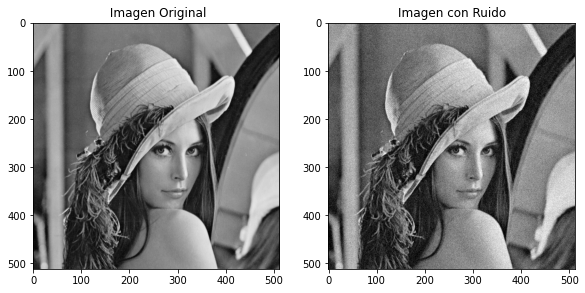

In [ ]:
plot_img(g, x, t = ' Imagen Original', r = 'Imagen con Ruido')

# Optimización

In [ ]:
g = np.array(g, dtype = np.float32)
x = np.array(x, dtype = np.float32)
n = x.shape[0]

# Fletcher-Reeves (FR)

In [ ]:
results_time = []
results_iter = []

## $\lambda = 0.1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FR',
          'f_params'     : {'g'     : g,
                           'lambda' : 0.1,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }
star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteración : 200
Iteración : 300
Iteración : 400
Iteración : 500
Iteración : 600
Iteración : 700
Iteración : 800
Iteración : 900
Iteración : 1000
Iteraciones:  1001  , valor:  [[159.67026  158.82724  159.64423  ... 167.90488  151.09984  118.35531 ]
 [158.0463   160.34677  157.67009  ... 168.17789  150.4281   120.09512 ]
 [157.87856  158.27805  159.78555  ... 167.00334  150.47989  118.54035 ]
 ...
 [ 20.510246  22.156881  28.486506 ...  91.72707   86.56394   85.37901 ]
 [ 21.840094  22.094923  35.012123 ...  91.33553   92.69639   96.009865]
 [ 22.483732  21.837072  34.758823 ...  91.72576   92.899254  95.68769 ]]


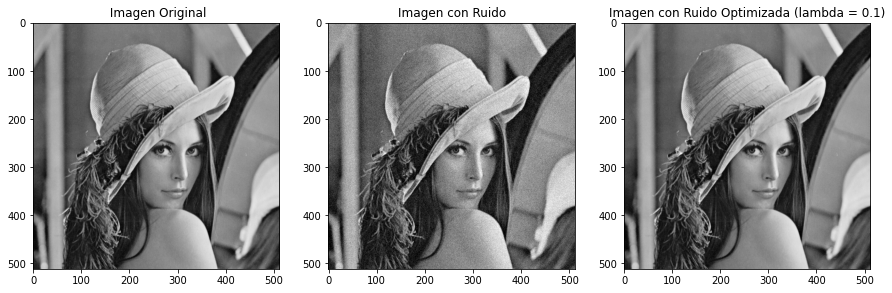

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 0.1)')

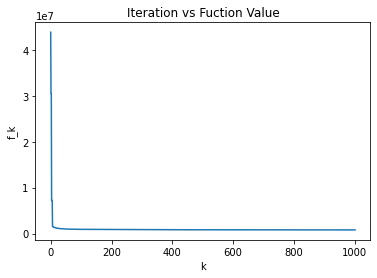

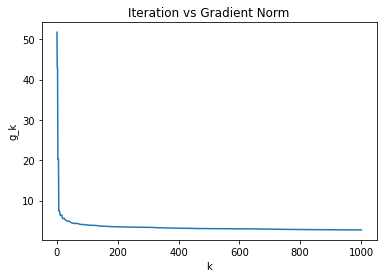

In [ ]:
get_graf(f_hist, g_hist)

## $\lambda = 1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FR',
          'f_params'     : {'g'     : g,
                           'lambda' : 1.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteración : 200
Iteración : 300
Iteración : 400
Iteración : 500
Iteración : 600
Iteración : 700
Iteración : 800
Iteración : 900
Iteración : 1000
Iteraciones:  1001  , valor:  [[158.79071  158.66306  158.55489  ... 167.58633  150.91325  119.8652  ]
 [158.72412  158.77167  158.52422  ... 167.33763  150.8103   120.03379 ]
 [158.90489  158.5576   158.51141  ... 167.50749  150.90779  119.70615 ]
 ...
 [ 22.378147  22.620613  28.38639  ...  89.99936   87.0054    85.99561 ]
 [ 22.568504  22.430605  32.461906 ...  91.495964  92.441025  94.480064]
 [ 22.378164  22.621206  32.54722  ...  91.49762   92.56652   94.522514]]


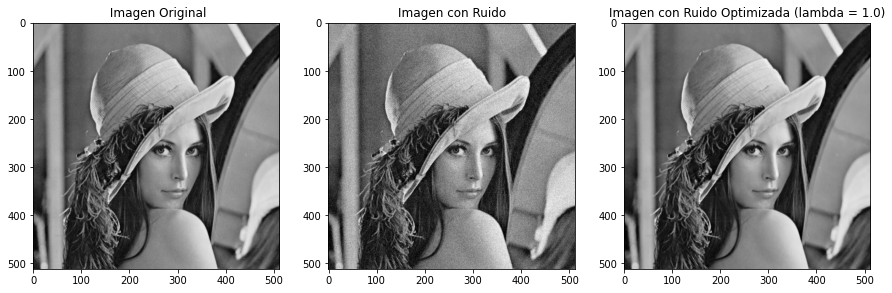

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 1.0)')

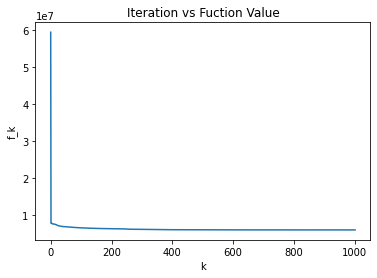

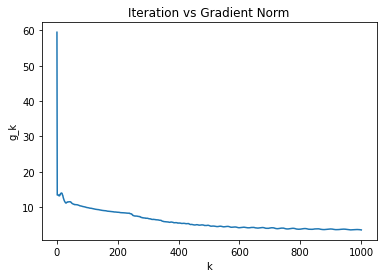

In [ ]:
get_graf(f_hist, g_hist)

## $\lambda = 2 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FR',
          'f_params'     : {'g'     : g,
                           'lambda' : 2.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteración : 200
Iteración : 300
Iteración : 400
Iteración : 500
Iteración : 600
Iteración : 700
Iteración : 800
Iteración : 900
Iteración : 1000
Iteraciones:  1001  , valor:  [[158.4833   158.71602  158.21773  ... 166.6499   150.71133  120.7513  ]
 [158.9751   158.23994  158.6832   ... 166.8019   150.82204  120.77298 ]
 [158.47797  158.78056  158.02905  ... 166.42953  150.53848  120.57608 ]
 ...
 [ 23.258894  23.61904   29.160181 ...  88.023125  87.12439   86.866066]
 [ 23.354576  23.26753   30.745594 ...  90.929344  91.975044  92.95039 ]
 [ 23.0448    23.446507  30.983475 ...  91.05687   92.02545   93.06945 ]]


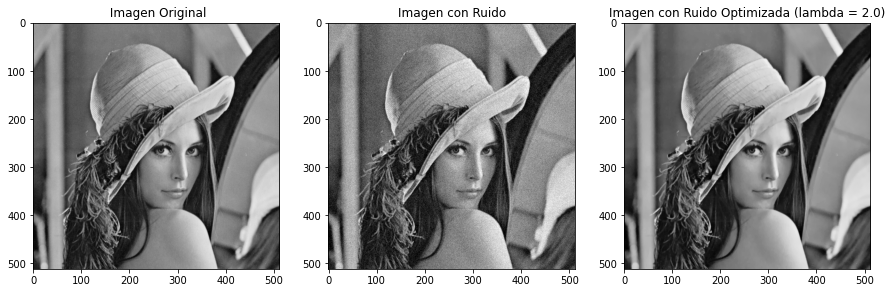

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 2.0)')

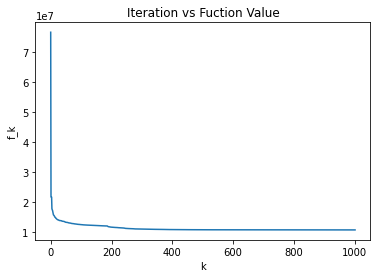

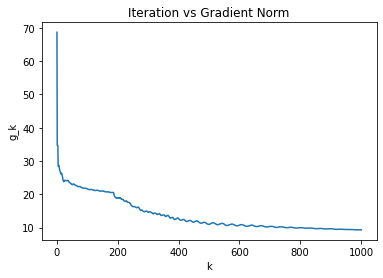

In [ ]:
get_graf(f_hist, g_hist)

## Resultados

In [ ]:
results = {'lambda = 0.1': {'Tiempo (seg)': results_time[0], 'Iteraciones': results_iter[0]}, 
            'lambda = 1.0': {'Tiempo (seg)': results_time[1], 'Iteraciones': results_iter[1]}, 
            'lambda = 2.0': {'Tiempo (seg)': results_time[2], 'Iteraciones': results_iter[2]}
            }
pd.DataFrame(results).T

,Tiempo (seg),Iteraciones
lambda = 0.1,293.755331,1002.0
lambda = 1.0,301.649890,1002.0
lambda = 2.0,322.231282,1002.0


# Polak-Ribiere (PR)

In [ ]:
results_time = []
results_iter = []

## $\lambda = 0.1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'PR',
          'f_params'     : {'g'     : g,
                           'lambda' : 0.1,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  59  , valor:  [[158.99722  158.97942  158.92958  ... 167.99048  151.00482  119.09705 ]
 [159.00334  158.95207  158.94882  ... 168.00336  150.98932  119.10475 ]
 [159.01846  158.9946   158.89905  ... 167.9631   150.98344  119.07356 ]
 ...
 [ 21.214838  21.272638  28.862238 ...  91.761055  87.00006   85.099815]
 [ 21.956251  22.016592  34.723053 ...  91.95556   92.93634   95.82811 ]
 [ 21.9969    22.04308   34.776894 ...  91.982994  92.96979   95.88284 ]]


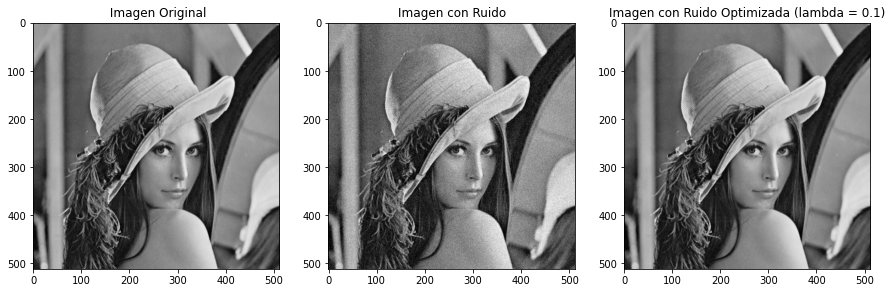

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 0.1)')

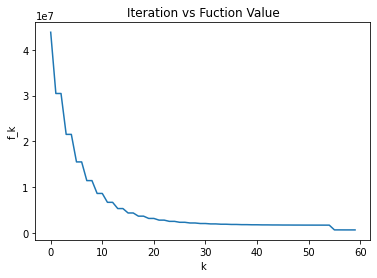

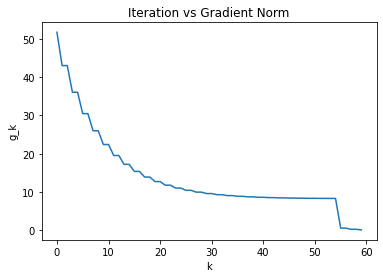

In [ ]:
get_graf(f_hist, g_hist)

## $ \lambda = 1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'PR',
          'f_params'     : {'g'     : g,
                           'lambda' : 1.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  91  , valor:  [[158.7625   158.73051  158.65091  ... 167.51474  150.8673   119.86822 ]
 [158.76715  158.73334  158.64671  ... 167.50131  150.85388  119.85479 ]
 [158.77841  158.74092  158.63493  ... 167.4722   150.8248   119.82569 ]
 ...
 [ 22.466496  22.520193  28.353584 ...  90.027054  87.03492   85.96953 ]
 [ 22.466572  22.520273  32.493416 ...  91.46921   92.479416  94.49102 ]
 [ 22.46661   22.520311  32.547104 ...  91.52275   92.53311   94.54472 ]]


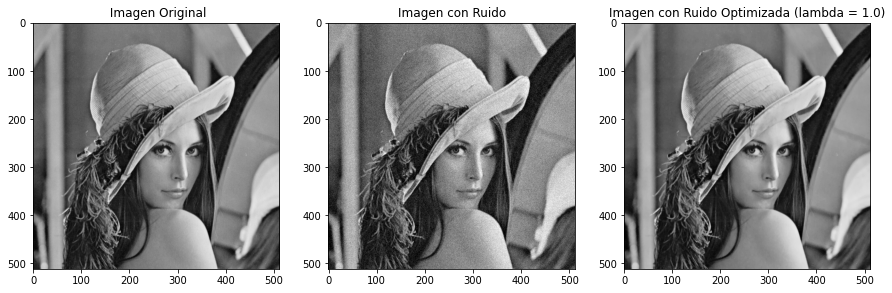

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 1.0)')

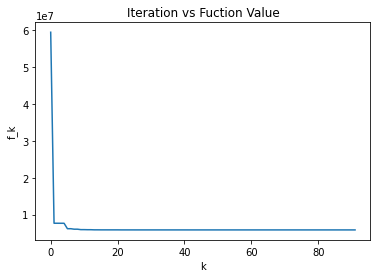

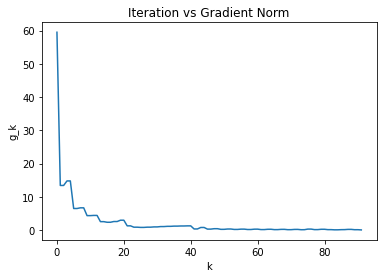

In [ ]:
get_graf(f_hist, g_hist)

## $\lambda = 2 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'PR',
          'f_params'     : {'g'     : g,
                           'lambda' : 2.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteración : 200
Iteraciones:  255  , valor:  [[158.34508  158.31636  158.24965  ... 166.68156  150.67339  120.68386 ]
 [158.33925  158.30939  158.23964  ... 166.66531  150.65715  120.66762 ]
 [158.32826  158.2957   158.21774  ... 166.6305   150.62233  120.6328  ]
 ...
 [ 23.318775  23.374388  29.185514 ...  88.06876   87.131805  86.87298 ]
 [ 23.285196  23.340813  30.747545 ...  90.97504   91.986046  93.01899 ]
 [ 23.269484  23.3251    30.802467 ...  91.03062   92.04166   93.0746  ]]


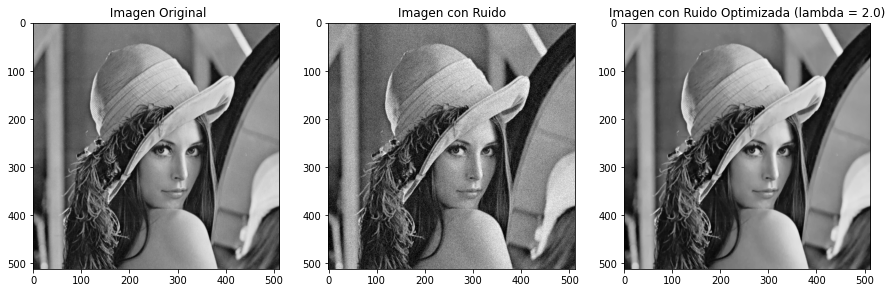

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 2.0)')

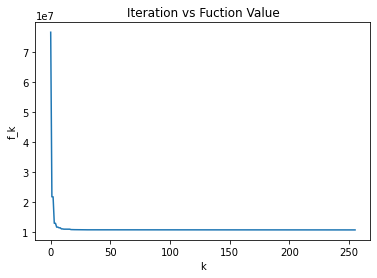

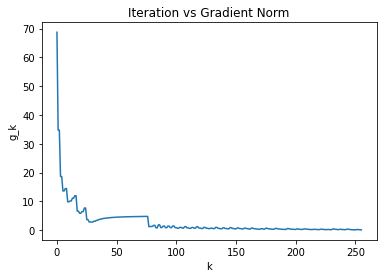

In [ ]:
get_graf(f_hist, g_hist)

## Resultados

In [ ]:
results = {'lambda = 0.1': {'Tiempo (seg)': results_time[0], 'Iteraciones': results_iter[0]}, 
            'lambda = 1.0': {'Tiempo (seg)': results_time[1], 'Iteraciones': results_iter[1]}, 
            'lambda = 2.0': {'Tiempo (seg)': results_time[2], 'Iteraciones': results_iter[2]}
            }
pd.DataFrame(results).T

,Tiempo (seg),Iteraciones
lambda = 0.1,19.106989,60.0
lambda = 1.0,26.305961,92.0
lambda = 2.0,73.805228,256.0


# Hestenes-Stiefel (HS)

In [ ]:
results_time = []
results_iter = []

## $ \lambda = 0.1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'HS',
          'f_params'     : {'g'     : g,
                           'lambda' : 0.1,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  47  , valor:  [[158.99261  159.00723  158.9137   ... 168.02084  151.01483  119.09033 ]
 [159.00159  158.96313  158.90656  ... 167.9484   150.97511  119.10495 ]
 [159.01067  158.99138  158.91316  ... 168.03151  150.99146  119.104195]
 ...
 [ 21.224283  21.273605  28.880686 ...  91.78627   87.00067   85.10028 ]
 [ 21.940193  22.009106  34.728325 ...  91.9346    92.93112   95.826836]
 [ 22.002176  22.049017  34.772076 ...  91.97866   92.969666  95.87367 ]]


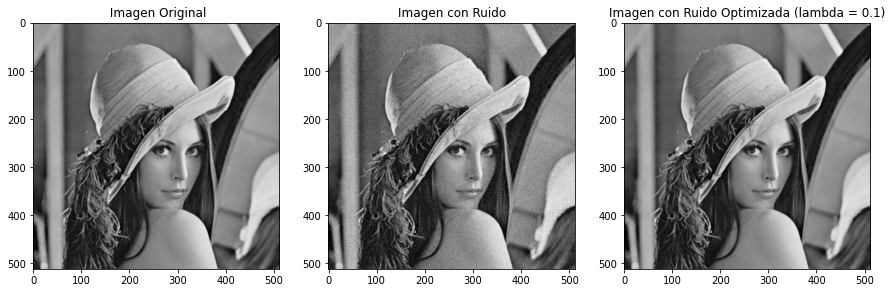

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 0.1)')

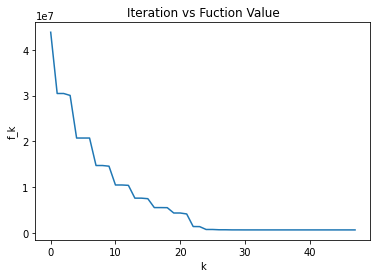

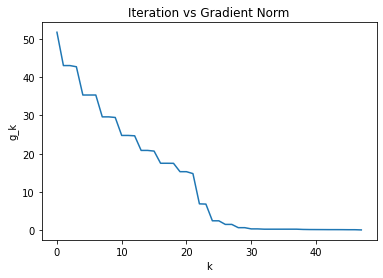

In [ ]:
get_graf(f_hist, g_hist)

## $ \lambda = 1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'HS',
          'f_params'     : {'g'     : g,
                           'lambda' : 1.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  71  , valor:  [[158.75748  158.72662  158.64474  ... 167.50858  150.86752  119.867676]
 [158.76503  158.72609  158.64108  ... 167.49411  150.854    119.854256]
 [158.7732   158.73933  158.62807  ... 167.46547  150.82492  119.82502 ]
 ...
 [ 22.47224   22.525093  28.354328 ...  90.00082   87.00232   85.99807 ]
 [ 22.471024  22.526472  32.478943 ...  91.47141   92.47617   94.47558 ]
 [ 22.472357  22.525211  32.532627 ...  91.52496   92.52987   94.52928 ]]


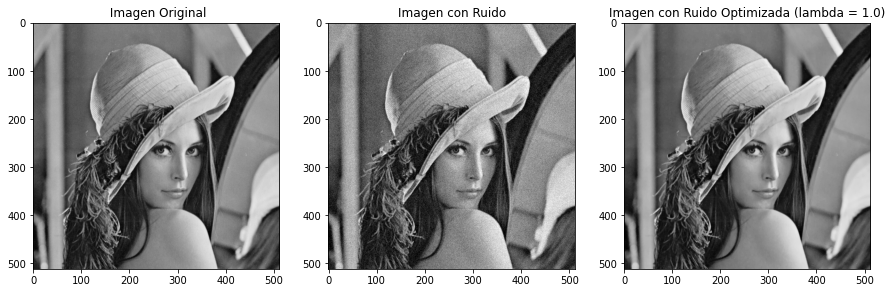

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 1.0)')

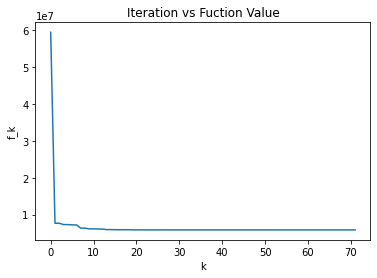

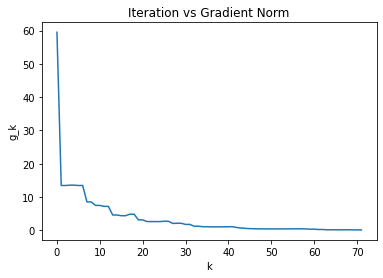

In [ ]:
get_graf(f_hist, g_hist)

## $ \lambda = 2.0 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'HS',
          'f_params'     : {'g'     : g,
                           'lambda' : 2.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteraciones:  137  , valor:  [[158.33458  158.30585  158.23923  ... 166.66711  150.68004  120.67979 ]
 [158.32874  158.2989   158.22928  ... 166.65083  150.66379  120.663536]
 [158.31773  158.28516  158.20746  ... 166.616    150.62897  120.628716]
 ...
 [ 23.330685  23.386347  29.188929 ...  88.02267   87.12008   86.8617  ]
 [ 23.297071  23.352732  30.736378 ...  90.96093   91.96901   92.9957  ]
 [ 23.281324  23.336988  30.791286 ...  91.01651   92.02462   93.05137 ]]


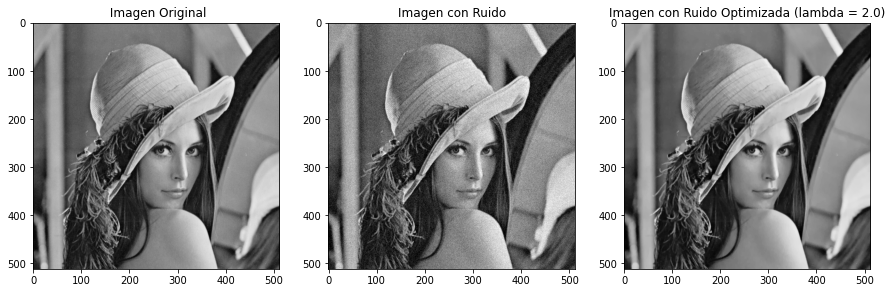

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 2.0)')

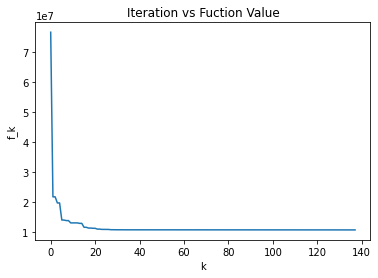

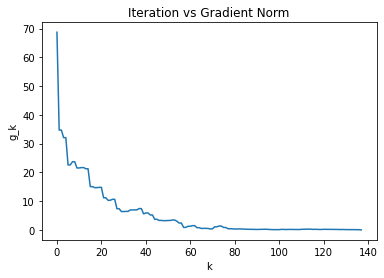

In [ ]:
get_graf(f_hist, g_hist)

## Resultados

In [ ]:
results = {'lambda = 0.1': {'Tiempo (seg)': results_time[0], 'Iteraciones': results_iter[0]}, 
            'lambda = 1.0': {'Tiempo (seg)': results_time[1], 'Iteraciones': results_iter[1]}, 
            'lambda = 2.0': {'Tiempo (seg)': results_time[2], 'Iteraciones': results_iter[2]}
            }
pd.DataFrame(results).T

,Tiempo (seg),Iteraciones
lambda = 0.1,9.562025,48.0
lambda = 1.0,20.527755,72.0
lambda = 2.0,38.797027,138.0


# FR-PR

In [ ]:
results_time = []
results_iter = []

## $ \lambda = 0.1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FRPR',
          'f_params'     : {'g'     : g,
                           'lambda' : 0.1,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  59  , valor:  [[158.99724  158.9794   158.92958  ... 167.99048  151.00482  119.09705 ]
 [159.0033   158.9521   158.94884  ... 168.00337  150.9893   119.10476 ]
 [159.01848  158.99458  158.89905  ... 167.96309  150.98346  119.073555]
 ...
 [ 21.21485   21.272635  28.862242 ...  91.76104   87.00008   85.09981 ]
 [ 21.956242  22.016596  34.72305  ...  91.95556   92.93633   95.8281  ]
 [ 21.996914  22.043068  34.776894 ...  91.982994  92.96978   95.882835]]


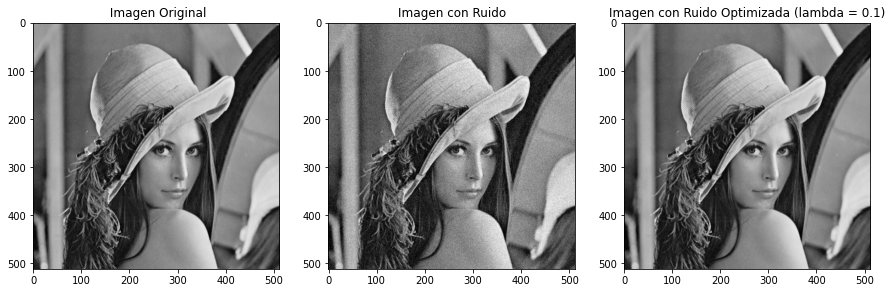

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 0.1)')

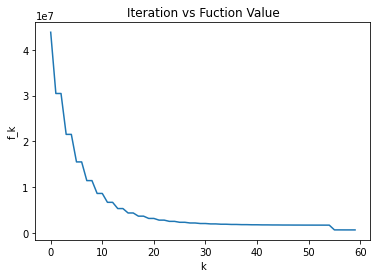

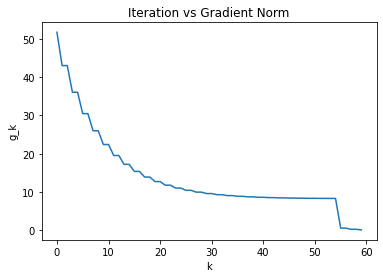

In [ ]:
get_graf(f_hist, g_hist)

## $ \lambda = 1 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FRPR',
          'f_params'     : {'g'     : g,
                           'lambda' : 1.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteraciones:  87  , valor:  [[158.76425  158.73207  158.65234  ... 167.5154   150.86731  119.86832 ]
 [158.76875  158.73517  158.6481   ... 167.50197  150.85388  119.85489 ]
 [158.78035  158.74251  158.63635  ... 167.47284  150.8248   119.825775]
 ...
 [ 22.466002  22.519701  28.353485 ...  90.029305  87.03736   85.96738 ]
 [ 22.466078  22.519781  32.494694 ...  91.46915   92.47961   94.49238 ]
 [ 22.466116  22.51982   32.548378 ...  91.52269   92.5333    94.546074]]


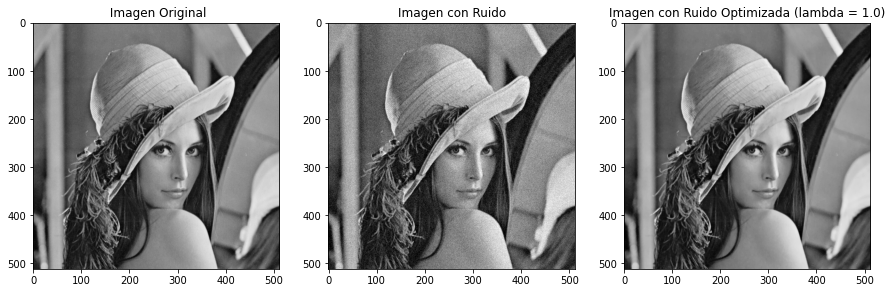

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 1.0)')

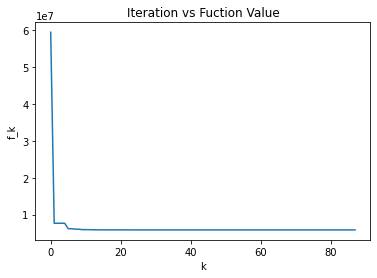

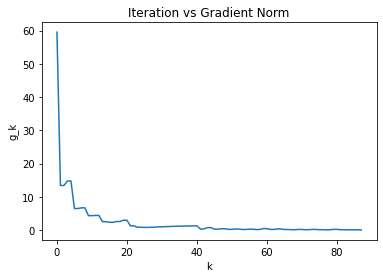

In [ ]:
get_graf(f_hist, g_hist)

## $ \lambda = 2 $

In [ ]:
params = {'x_0'          : x,
          'f'            : f, 
          'f_grad'       : f_grad,
          'max_iter'     : 1000, 
          'tau_grad'     : 1e-1,
          'method'       : 'FRPR',
          'f_params'     : {'g'     : g,
                           'lambda' : 2.0,
                           'n'      : n
                           },
          'BackTracking' : {'alpha' : 0.9,
                            'ro'    : 0.5,
                            'c1'    : 1e-4,
                            }
          }

star = time.time()

f_hist, g_hist, x_k_next = non_linear_conjugate_gradient(params, show_logs = False)

results_time.append(time.time() - star)
results_iter.append(f_hist.shape[0])

Iteración : 100
Iteración : 200
Iteraciones:  276  , valor:  [[158.3448   158.31609  158.24937  ... 166.6811   150.67355  120.68376 ]
 [158.33896  158.3091   158.23935  ... 166.66487  150.65732  120.66752 ]
 [158.32797  158.29541  158.21745  ... 166.63005  150.6225   120.6327  ]
 ...
 [ 23.319078  23.374691  29.185686 ...  88.06769   87.131645  86.872826]
 [ 23.2855    23.341114  30.747211 ...  90.97481   91.98571   93.01813 ]
 [ 23.269785  23.325401  30.802134 ...  91.03039   92.04132   93.07374 ]]


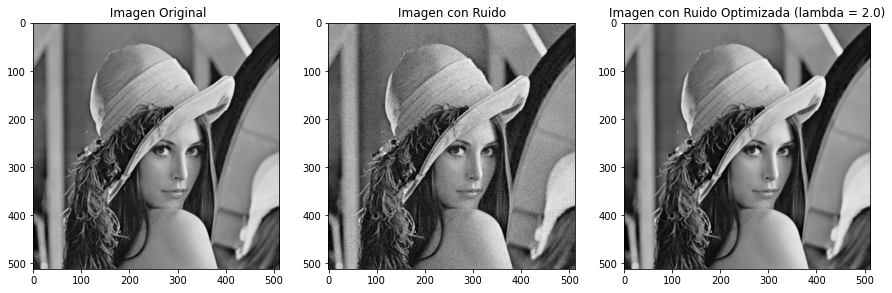

In [ ]:
plot_img(g, x, x_k_next, t = ' Imagen Original', r = 'Imagen con Ruido', s = 'Imagen con Ruido Optimizada (lambda = 2.0)')

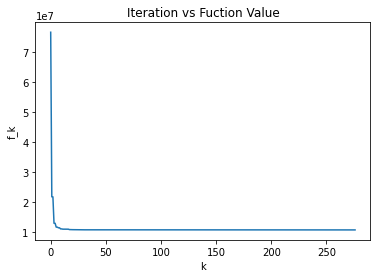

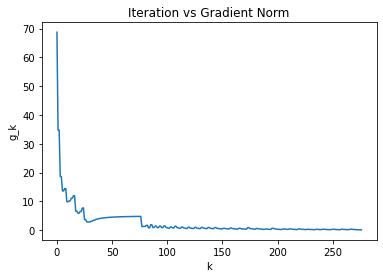

In [ ]:
get_graf(f_hist, g_hist)

## Resultados

In [ ]:
results = {'lambda = 0.1': {'Tiempo (seg)': results_time[0], 'Iteraciones': results_iter[0]}, 
            'lambda = 1.0': {'Tiempo (seg)': results_time[1], 'Iteraciones': results_iter[1]}, 
            'lambda = 2.0': {'Tiempo (seg)': results_time[2], 'Iteraciones': results_iter[2]}
            }
pd.DataFrame(results).T

,Tiempo (seg),Iteraciones
lambda = 0.1,14.190665,60.0
lambda = 1.0,21.855461,88.0
lambda = 2.0,75.199838,277.0
